#### Load the captions

In [1]:
!pip install simplejson

     |████████████████████████████████| 130 kB 5.2 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import string
import string
import numpy as np
import pandas as pd
from numpy import array
from pickle import load
import simplejson as json
from PIL import Image
import pickle
from collections import Counter
import matplotlib.pyplot as plt
import glob
import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re

import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from keras.layers.merge import add
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [4]:
filePath = '/content/drive/MyDrive/Group Project - CMPE 258 (Fall 21)/annotations 2/'

In [5]:
data = json.load(open( filePath + 'train.json', 'r'))
dataset = {}
for key, value in data.items():
  if key != 'annotations':
    dataset[key] = value
dataset['annotations'] = []
for annotation in data['annotations']:
  dataset['annotations'].append(annotation)

In [6]:
image_id = set()
captions = list()
for annotation in dataset['annotations']:
  image_id.add(annotation['image_id'])
  captions.append(annotation['caption'])

In [7]:
df_annotations = pd.json_normalize(dataset, record_path =['annotations'])

In [8]:
df_annotations

,caption,image_id,is_precanned,is_rejected,id,text_detected
0,ITS IS A BASIL LEAVES CONTAINER ITS CONTAINS T...,0,False,False,0,True
1,A green and white plastic condiment bottle con...,0,False,False,1,True
2,Quality issues are too severe to recognize vis...,0,True,True,2,True
3,A bottle of spices in a plastic container layi...,0,False,False,3,True
4,some basil leaves in a container on a counter,0,False,False,4,True
...,...,...,...,...,...,...
117150,The back of a plastic card such as a credit ca...,23430,False,False,117150,True
117151,A card is seen with a scratch strip to reveal ...,23430,False,False,117151,True
117152,The back of a gift card without the silver str...,23430,False,False,117152,True
117153,The back of a plastic money or credit card wit...,23430,False,False,117153,True


only consider the captions for 1001 images

In [9]:
df_annotations = df_annotations[0:5005]

In [10]:
df_annotations

,caption,image_id,is_precanned,is_rejected,id,text_detected
0,ITS IS A BASIL LEAVES CONTAINER ITS CONTAINS T...,0,False,False,0,True
1,A green and white plastic condiment bottle con...,0,False,False,1,True
2,Quality issues are too severe to recognize vis...,0,True,True,2,True
3,A bottle of spices in a plastic container layi...,0,False,False,3,True
4,some basil leaves in a container on a counter,0,False,False,4,True
...,...,...,...,...,...,...
5000,A image of creamy tomato broth on top of a bla...,1000,False,False,5000,True
5001,A package of organic creamy tomato soup with l...,1000,False,False,5001,True
5002,A box of packaged tomato soup is displayed.,1000,False,False,5002,True
5003,A rectangular carton that contains tomato past...,1000,False,False,5003,True


### Only consider isPrecanned = false captions

In [11]:
df_annotations_No_precanned = df_annotations[df_annotations["is_precanned"] == False]

In [12]:
df_annotations_No_precanned = df_annotations_No_precanned.reset_index()

In [13]:
imageId = set(range(0, 1001))

In [14]:
imageIds = set() 
for i in range(len(df_annotations_No_precanned)):
  id = df_annotations_No_precanned["image_id"][i]
  imageIds.add(id)

In [15]:
missing_imageIds = imageId.difference(imageIds)

In [16]:
missing_imageIds

{19, 30, 155, 262, 273, 292, 308, 347, 481, 594, 605, 606, 677, 792, 819}

### make a dictionary to store image_id and corresponding captions

In [17]:
imageId_path = dict()
for i in range(0, len(df_annotations_No_precanned)):
  id = df_annotations_No_precanned["image_id"][i]
  if( id not in missing_imageIds):
    number_str = str(id) 
    df_annotations_No_precanned["image_id"][i] = 'VizWiz_train_' + number_str.zfill(8)
    imageId_path[df_annotations_No_precanned["image_id"][i]] = id
    print(df_annotations_No_precanned["image_id"][i])

VizWiz_train_00000000
VizWiz_train_00000000
VizWiz_train_00000000
VizWiz_train_00000000
VizWiz_train_00000001
VizWiz_train_00000001
VizWiz_train_00000001
VizWiz_train_00000001
VizWiz_train_00000001
VizWiz_train_00000002
VizWiz_train_00000002
VizWiz_train_00000002
VizWiz_train_00000002
VizWiz_train_00000002
VizWiz_train_00000003
VizWiz_train_00000003
VizWiz_train_00000003
VizWiz_train_00000003
VizWiz_train_00000003
VizWiz_train_00000004
VizWiz_train_00000004
VizWiz_train_00000004
VizWiz_train_00000004
VizWiz_train_00000004
VizWiz_train_00000005
VizWiz_train_00000005
VizWiz_train_00000005
VizWiz_train_00000005
VizWiz_train_00000006
VizWiz_train_00000006
VizWiz_train_00000006
VizWiz_train_00000006
VizWiz_train_00000006
VizWiz_train_00000007
VizWiz_train_00000007
VizWiz_train_00000007
VizWiz_train_00000007
VizWiz_train_00000007
VizWiz_train_00000008
VizWiz_train_00000008
VizWiz_train_00000008
VizWiz_train_00000008
VizWiz_train_00000008
VizWiz_train_00000009
VizWiz_train_00000009
VizWiz_tra

### operation to convert the image_id to the name stored in the dataset.

In [18]:
descriptions = dict()
for i in range(0, len(df_annotations_No_precanned)):
  caption = df_annotations_No_precanned["caption"][i]
  tokens = caption
  image_id = df_annotations_No_precanned["image_id"][i]
  if image_id not in descriptions:
    descriptions[image_id] = list()
  descriptions[image_id].append(tokens)

In [77]:
len(descriptions)

986

### Text Processing utilities

In [19]:
def remove_punctuation(text_original):
   text_no_punctuation = text_original.translate(string.punctuation)
   return(text_no_punctuation)

def remove_single_character(text):
   text_len_more_than1 = ""
   for word in text.split():
       if len(word) > 1:
           text_len_more_than1 += " " + word
   return(text_len_more_than1)

def remove_numeric(text):
   text_no_numeric = ""
   for word in text.split():
       isalpha = word.isalpha()
       if isalpha:
           text_no_numeric += " " + word
   return(text_no_numeric)

def text_clean(text_original):
   text = remove_punctuation(text_original)
   text = remove_single_character(text)
   text = remove_numeric(text)
   return(text)

### Clean the captions reside in descriptions dict

In [20]:
table = str.maketrans('', '', string.punctuation)
for image_id, captions in descriptions.items():
    for i in range(len(captions)):
        desc = captions[i].split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        captions[i] =  ' '.join(desc)

In [21]:
descriptions["VizWiz_train_00000000"]

['its is a basil leaves container its contains the net weight too',
 'a green and white plastic condiment bottle containing basil leaves',
 'a bottle of spices in a plastic container laying on a surface',
 'some basil leaves in a container on a counter']

In [ ]:
#descriptions["VizWiz_train_00000000"]

['  i t s   i s   b a s i l   l e a v e s   c o n t a i n e r   i t s   c o n t a i n s   t h e   n e t   w e i g h t   t o o',
 '  g r e e n   a n d   w h i t e   p l a s t i c   c o n d i m e n t   b o t t l e   c o n t a i n i n g   b a s i l   l e a v e s',
 '  q u a l i t y   i s s u e s   a r e   t o o   s e v e r e   t o   r e c o g n i z e   v i s u a l   c o n t e n t',
 '  b o t t l e   o f   s p i c e s   i n   p l a s t i c   c o n t a i n e r   l a y i n g   o n   s u r f a c e',
 '  s o m e   b a s i l   l e a v e s   i n   c o n t a i n e r   o n   c o u n t e r']

In [ ]:
# for image_id, captions in descriptions.items():
#     for i in range(len(captions)):
#         desc = text_clean(captions[i])
#         captions[i] =  ' '.join(desc)

### Visualize the image with captions

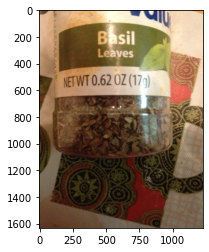

['its is a basil leaves container its contains the net weight too',
 'a green and white plastic condiment bottle containing basil leaves',
 'a bottle of spices in a plastic container laying on a surface',
 'some basil leaves in a container on a counter']

In [22]:
images_path = "/content/drive/MyDrive/Group Project - CMPE 258 (Fall 21)/Dataset/train/"
pic = 'VizWiz_train_00000000.jpg'
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
descriptions['VizWiz_train_00000000']

### Total vocabulary size

In [ ]:
# vocabulary = []
# for txt in df_annotations.caption.values:
#    vocabulary.extend(txt.split())
# print('Vocabulary Size: %d' % len(set(vocabulary)))

Vocabulary Size: 2166


In [23]:
vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 4025


### Create list of image path

In [24]:
img = glob.glob(images_path + '*.jpg')

In [25]:
img[56][len(images_path):]

'VizWiz_train_00000101.jpg'

In [26]:
train_images = list() 
test_images = list()
count = 0
for key in descriptions.keys():
  if count > 900 : 
    test_images.append(key + ".jpg")
  else:
    train_images.append(key + ".jpg")
  count += 1

In [27]:
len(test_images)

85

In [28]:
train_img = []
for i in img: 
    if i[len(images_path):] in train_images:
        train_img.append(i)

In [29]:
len(train_img)

901

In [30]:
test_img = []
for i in img: 
    if i[len(images_path):] in test_images:
        test_img.append(i)

### Create train description dict with captions starting with startseq and ends with endsq

In [31]:
train_descriptions = dict()
test_descriptions = dict()
count = 0
for image_id , captions in descriptions.items(): 
    for i in range(len(captions)):
      desc = 'startseq ' + ''.join(captions[i]) + ' endseq'
      if count > 900 :
        if image_id not in test_descriptions:
          test_descriptions[image_id] = list()
        test_descriptions[image_id].append(desc)
      else:
        if image_id not in train_descriptions:
          train_descriptions[image_id] = list()
        train_descriptions[image_id].append(desc)
      #descriptions[image_id][i] = desc
    count += 1

In [32]:
len(test_descriptions)

85

In [33]:
train_descriptions['VizWiz_train_00000000']

['startseq its is a basil leaves container its contains the net weight too endseq',
 'startseq a green and white plastic condiment bottle containing basil leaves endseq',
 'startseq a bottle of spices in a plastic container laying on a surface endseq',
 'startseq some basil leaves in a container on a counter endseq']

### List of all captions

In [34]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

In [35]:
all_test_captions = []
for key, val in test_descriptions.items():
    for cap in val:
        all_test_captions.append(cap)

In [36]:
len(all_test_captions)

389

### Reduce the vocabulary size

In [37]:
vocab = []
for captions in descriptions.values():
   for caption in captions:
     vocab.extend(caption.split())
print('Clean Vocabulary Size: %d' % len(set(vocab)))

Clean Vocabulary Size: 4025


In [ ]:
word_count_threshold = 1 
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 39


### Create word embedding

In [38]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

In [39]:
all_desc = list()
for key in descriptions.keys():
    [all_desc.append(d) for d in descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

Description Length: 54


### Glove embedding

In [40]:
glove_path = "/content/drive/MyDrive/Group Project - CMPE 258 (Fall 21)/"
embeddings_index = {} 
f = open(os.path.join(glove_path, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

#### Create embedding matrix

In [41]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### Model building (Inception V3 - LSTM)

In [134]:
model = InceptionV3(weights='imagenet')

96124928/96112376 [==============================] - 1s 0us/step


In [135]:
model_new = Model(model.input, model.layers[-2].output)

In [136]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [137]:
encode(train_img[1])

array([0.13323548, 0.1040376 , 0.34345636, ..., 0.39415476, 0.        ,
       0.00439453], dtype=float32)

In [138]:
def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

encoding_train = {}
for img in train_img:
    encoding_train[img[len(images_path):]] = encode(img)
train_features = encoding_train

In [ ]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 239)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 239, 200)     8000        ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

#### Transfer learning

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

#### Train the model in batches

In [ ]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:
epochs = 30
batch_size = 3
steps = len(descriptions)//batch_size

generator = data_generator(descriptions, train_features, wordtoix, max_length, batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/30
333/333 [==============================] - 184s 552ms/step - loss: 1.2504
Epoch 2/30
333/333 [==============================] - 184s 554ms/step - loss: 1.1041
Epoch 3/30
333/333 [==============================] - 185s 554ms/step - loss: 1.0245
Epoch 4/30
333/333 [==============================] - 183s 550ms/step - loss: 0.9718
Epoch 5/30
333/333 [==============================] - 183s 550ms/step - loss: 0.9306
Epoch 6/30
333/333 [==============================] - 184s 553ms/step - loss: 0.8980
Epoch 7/30
333/333 [==============================] - 183s 551ms/step - loss: 0.8709
Epoch 8/30
333/333 [==============================] - 183s 549ms/step - loss: 0.8483
Epoch 9/30
333/333 [==============================] - 183s 550ms/step - loss: 0.8277
Epoch 10/30
333/333 [==============================] - 183s 549ms/step - loss: 0.8087
Epoch 11/30
333/333 [==============================] - 183s 550ms/step - loss: 0.7928
Epoch 12/30
333/333 [==============================] - 182s 546

### Model (VGG16 + LSTM (GRU))

In [42]:
model = tf.keras.applications.VGG16(include_top=True, weights='imagenet')

553476096/553467096 [==============================] - 7s 0us/step


In [43]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [44]:
model_new = Model(model.input, model.layers[-4].output)
model_new.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [45]:
ENCODER_OUTPUT_DIM = model_new.output_shape[1]
ENCODER_INPUT_DIM = (model_new.input_shape[1],model_new.input_shape[2])

In [46]:
def preprocess(image_path, size):
    img = image.load_img(image_path, target_size=(size, size))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [133]:
def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

encoding_train = {}
for img in train_img:
    encoding_train[img[len(images_path):]] = encode(img)
train_features = encoding_train

ValueError: ignored

### Greedy and beam search

In [ ]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

### Evaluation

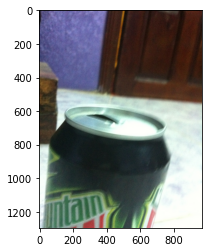

Greedy Search: 
Beam Search, K = 3: a   p e r s o n   i s   h o l d i n g   o n t o   a   c a n   w i t h   a   c a n   o f   b e e r
Beam Search, K = 5: a   p e r s o n   i s   h o l d i n g   o n t o   a   c a n   o f   f o o d
Beam Search, K = 7: q u a l i t y   i s s u e s   a r e   t o o   s e v e r e   t o   r e c o g n i z e   v i s u a l   c o n t e n t
Beam Search, K = 10: q u a l i t y   i s s u e s   a r e   t o o   s e v e r e   t o   r e c o g n i z e   v i s u a l   c o n t e n t


In [ ]:
pic = 'VizWiz_train_00000078.jpg'
image = encoding_train[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

Problem of generating the image caption is that, there are multiple correct answers to describe the image. So the challenge here to create a metric which helps to correctly evaluates the model. Bleu score allows to measure how good the machine generated captions is compared to the caption references given by the humans. Bleu (Billingual evaluation understudy) study if the machine generted caption's word are present in any of the references caption. 

Reason of not using the precision metrice: Because if the machine generated caption has only one type of words multiple times. And that word present in the all the reference caption then precision would be 1 but this measure is misleading. 

So Blue score tells to which degree machine generated captions are overlapped with the given references. So it is the ,metrics we can use whenever we need to compare the text generated by machine with the test captions to know is the context and content is overlaping or not. 

